In [1]:
from scipy import stats
import numpy as np

import ABC,ABC_Cross_Validation
from Models import LinearModel,ExponentialModel,SIRModel

# Validation
Here I apply Leave-one-Out Cross-Validation to compare the variations on ABC methods I have applied

**Leave-one-Out Cross-Validation**

Cross-Validation allows us to compare the performance of different machine learning methods.

Leave-one-Out Cross-Validation involves
<ol>
    <li>Selecting one element $(x,y)$ from the training set ($(x_obs,y_obs)$).</li>
    <li>Training the model using the whole training set except $(x,y)$.</li>
    <li>Evaluating the models prediction for $(x,y)$. (e.g. RMSE)</li>
    <li>Repeating 1.-3. leaving a different data-point out each time.</li>
    <li>Choose model with the lowest total error.</li>
</ol>




**Table of Contents**
 * [Linear Model](#Linear-Model)
     * [ABC-Rejection](#linear-rejection)
     * [ABC-MCMC](#linear-mcmc)
     * [ABC-SMC](#linear-smc)
 * [Exponential Model](#Exponential-Model)
     * [ABC-Rejection](#exponential-rejection)
     * [ABC-MCMC](#exponential-mcmc)
     * [ABC-SMC](#exponential-smc)
 * [SIR Model](#SIR-Model)
     * [ABC-Rejection](#sir-rejection)
     * [ABC-MCMC](#sir-mcmc)
     * [ABC-SMC](#sir-smc)

## Linear Model

In [2]:
np.random.seed(16111998) # Fix random seed
lm=LinearModel(  # 1+10x
    n_params=2,
    params=[1,10],
    n_vars=1,
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=30
    )
lm_priors=[stats.uniform(0,6),stats.uniform(8,6)]

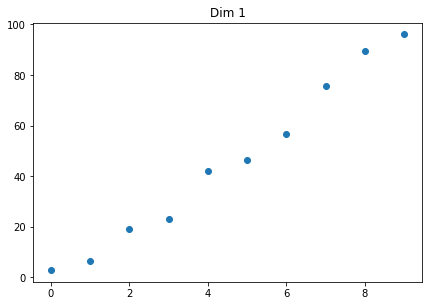

In [3]:
lm.plot_obs()

In [4]:
start = (lambda ys:[10*ys[0][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,mean_grad]

<a id="linear-rejection"></a>

In [5]:
%%time
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":3500,"sample_size":350}
error=ABC_Cross_Validation.LOO_CV_abc_rejection(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

1/10. Predicted -  [13.423990460735741] . Actual -  [6.582033773389246] . Error - 6.842
2/10. Predicted -  [24.282673109287565] . Actual -  [19.352977309887507] . Error - 4.930
3/10. Predicted -  [34.592084021505826] . Actual -  [23.073409099211318] . Error - 11.519
4/10. Predicted -  [45.729993296872834] . Actual -  [42.002592041406075] . Error - 3.727
5/10. Predicted -  [56.346769149863285] . Actual -  [46.240787044118285] . Error - 10.106
6/10. Predicted -  [67.03125111616018] . Actual -  [56.52241872907294] . Error - 10.509
7/10. Predicted -  [76.13188594378798] . Actual -  [75.75469430652853] . Error - 0.377
8/10. Predicted -  [88.72039059905147] . Actual -  [89.52725765204846] . Error - 0.807
9/10. Predicted -  [100.45481943057402] . Actual -  [96.057868970883] . Error - 4.397
Total error : 53.214
Wall time: 4min 16s


<a id="linear-mcmc"></a>

In [6]:
%%time
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x+stats.norm(0,.5).rvs(1)[0]]*2

error=ABC_Cross_Validation.LOO_CV_abc_mcmc(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),
    fitting_model=lm.copy([1,1]),priors=lm_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.uniform_kernel,scaling_factor=4,chain_length=3500,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

1/10. Predicted -  [13.222305396616704] . Actual -  [6.582033773389246] . Error - 6.640
2/10. Predicted -  [24.113430346773747] . Actual -  [19.352977309887507] . Error - 4.760
3/10. Predicted -  [35.92309144137307] . Actual -  [23.073409099211318] . Error - 12.850
4/10. Predicted -  [45.361551202271] . Actual -  [42.002592041406075] . Error - 3.359
5/10. Predicted -  [55.531969630622925] . Actual -  [46.240787044118285] . Error - 9.291
6/10. Predicted -  [67.05826965491384] . Actual -  [56.52241872907294] . Error - 10.536
7/10. Predicted -  [77.30291319344317] . Actual -  [75.75469430652853] . Error - 1.548
8/10. Predicted -  [86.00448200744677] . Actual -  [89.52725765204846] . Error - 3.523
9/10. Predicted -  [101.6202730505271] . Actual -  [96.057868970883] . Error - 5.562
Total error : 58.070
Wall time: 4min 41s


<a id="linear-smc"></a>

In [7]:
%%time
np.random.seed(16111998) # Fix random seed
scaling_factors=list(np.linspace(10,6,5))

perturbance_variance=.1

perturbance_kernels = [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]

error=ABC_Cross_Validation.LOO_CV_abc_smc(n_obs=10,x_obs=lm.x_obs,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,
        perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
        num_steps=5,sample_size=50,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

(627) - 50/50/50
(4/5 - 1,501) - 49/50 (6.000)
Total Simulations - 3,587
theta_hat - [2.1320786725059278, 10.111462420821875]
Predicted -  [12.243541093327803] . Actual -  [6.582033773389246] . Error - 5.662
(922) - 50/50/50
(4/5 - 1,861) - 49/50 (6.000)
Total Simulations - 4,967
theta_hat - [1.5727794504426507, 10.238022163713769]
Predicted -  [22.048823777870187] . Actual -  [19.352977309887507] . Error - 2.696
(683) - 50/50/50
(4/5 - 926) - 49/50 (6.000)
Total Simulations - 2,696
theta_hat - [2.406377487281877, 10.069996703554036]
Predicted -  [32.616367597943984] . Actual -  [23.073409099211318] . Error - 9.543
(607) - 50/50/50
(4/5 - 1,683) - 49/50 (6.000)
Total Simulations - 3,910
theta_hat - [1.1309739564146903, 10.22541218276422]
Predicted -  [42.03262268747157] . Actual -  [42.002592041406075] . Error - 0.030
(571) - 50/50/50
(4/5 - 1,423) - 49/50 (6.000)
Total Simulations - 3,185
theta_hat - [1.0886130444451592, 10.329348373119759]
Predicted -  [52.73535491004395] . Actual - 

## Exponential Model

In [5]:
# Specify the model
np.random.seed(16111998) # Fix random seed
em=ExponentialModel(
    params=[2,.3],
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=.1,
)

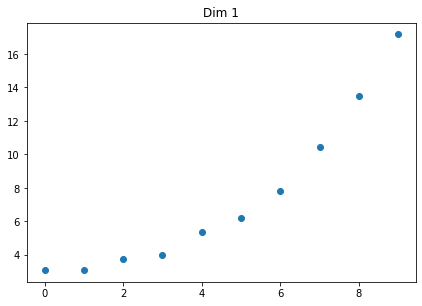

In [6]:
# Plot the observations
em.plot_obs()

In [7]:
em_priors=[stats.uniform(0,3),stats.uniform(0,1)]

In [8]:
# Define summary statistics
start = (lambda ys:[ys[0][0]])
mean_log_grad = (lambda ys:[10*np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,mean_log_grad]

<a id="exponential-rejection"></a>

In [14]:
%%time
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":3500,"sample_size":350}
error=ABC_Cross_Validation.LOO_CV_abc_rejection(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

0/10. Predicted -  [2.55603604] . Actual -  [3.11258724] . Error - 0.557
1/10. Predicted -  [3.02092325] . Actual -  [3.09478741] . Error - 0.074
2/10. Predicted -  [3.43942115] . Actual -  [3.7270279] . Error - 0.288
3/10. Predicted -  [4.10763407] . Actual -  [4.00196117] . Error - 0.106
4/10. Predicted -  [5.09811393] . Actual -  [5.3780016] . Error - 0.280
5/10. Predicted -  [6.3280892] . Actual -  [6.20691578] . Error - 0.121
6/10. Predicted -  [7.69860845] . Actual -  [7.79113419] . Error - 0.093
7/10. Predicted -  [10.05630072] . Actual -  [10.44068232] . Error - 0.384
8/10. Predicted -  [12.87345332] . Actual -  [13.51549783] . Error - 0.642
9/10. Predicted -  [17.67183997] . Actual -  [17.17174793] . Error - 0.500
Total error : 3.044
Wall time: 4min 24s


<a id="exponential-mcmc"></a>

In [9]:
%%time
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2

error=ABC_Cross_Validation.LOO_CV_abc_mcmc(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),
    fitting_model=em.copy([1,1]),priors=em_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factor=2,chain_length=3500,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

Found Start - (46)5,2.139)                                           [0.8649966997090638, 0.29866811795554515]
0.212 observations were new.
Predicted -  [2.38283625] . Actual -  [3.11258724] . Error - 0.730
Found Start - (3) [2.6456318735105295, 0.316861602985829]           
0.211 observations were new.
Predicted -  [2.90511616] . Actual -  [3.09478741] . Error - 0.190
Found Start - (3) [2.3552949968959696, 0.25405053358898544]         
0.226 observations were new.
Predicted -  [3.8986815] . Actual -  [3.7270279] . Error - 0.172
Found Start - (5) [1.1387935968338045, 0.33402081123874017]         
0.196 observations were new.
Predicted -  [3.77494031] . Actual -  [4.00196117] . Error - 0.227
Found Start - (13) [2.277647213673055, 0.3403426857505998]          
0.231 observations were new.
Predicted -  [5.07306972] . Actual -  [5.3780016] . Error - 0.305
Found Start - (6) [0.6339765524844626, 0.3212972426304129]          
0.216 observations were new.
Predicted -  [5.74064636] . Actual -  

<a id="exponential-smc"></a>

In [15]:
%%time
np.random.seed(16111998) # Fix random seed
scaling_factors=list(np.linspace(4,1,3))

perturbance_variance=.1

perturbance_kernels = [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]

error=ABC_Cross_Validation.LOO_CV_abc_smc(n_obs=10,x_obs=em.x_obs,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,
        perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
        num_steps=3,sample_size=50,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

(1,007) - 50/500
(2/3 - 1,936) - 49/50 (1.000)
Total Simulations - 3,339
theta_hat - [1.754750170963507, 0.3032985509299142]
Predicted -  [2.75475017] . Actual -  [3.11258724] . Error - 0.358
(1,029) - 50/500
(2/3 - 3,212) - 49/50 (1.000)
Total Simulations - 4,708
theta_hat - [1.8597503110791884, 0.30551462405824464]
Predicted -  [3.21707365] . Actual -  [3.09478741] . Error - 0.122
(1,146) - 50/500
(2/3 - 2,931) - 49/50 (1.000)
Total Simulations - 4,550
theta_hat - [1.8199866207278785, 0.3031535687712366]
Predicted -  [3.65363409] . Actual -  [3.7270279] . Error - 0.073
(1,400) - 50/500
(2/3 - 2,737) - 49/50 (1.000)
Total Simulations - 4,810
theta_hat - [2.056159009249509, 0.30184868385068947]
Predicted -  [4.5294411] . Actual -  [4.00196117] . Error - 0.527
(1,285) - 50/500
(2/3 - 2,285) - 49/50 (1.000)
Total Simulations - 4,158
theta_hat - [1.9339586082188367, 0.30296938878951646]
Predicted -  [5.29374553] . Actual -  [5.3780016] . Error - 0.084
(981) - 50/50/50
(2/3 - 2,884) - 49/5

## SIR Model

In [22]:
sir_model=SIRModel(
    params=[100000,100,1,.5],
    n_obs=30,
    x_obs=[[x] for x in range(30)],)
sir_priors=[stats.uniform(100000,0),stats.uniform(100,0),stats.uniform(0,1.5),stats.uniform(0,2)]
sir_smc_priors=[stats.uniform(100000,1),stats.uniform(100,1),stats.uniform(0,1.5),stats.uniform(0,2)]

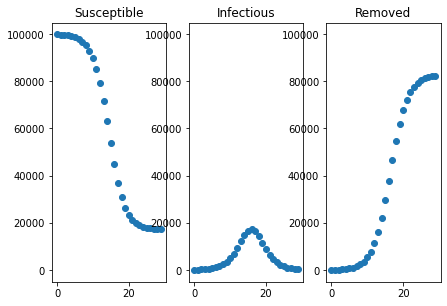

In [23]:
sir_model.plot_obs(constant_scale=True)

In [24]:
peak_infections_date_ss=(lambda ys:[1000*ys.index(max(ys,key=lambda y:y[1]))])
peak_infections_value_ss=(lambda ys:[max(ys,key=lambda y:y[1])[1]])
summary_stats=[peak_infections_date_ss,peak_infections_value_ss]

<a id="sir-rejection"></a>

In [5]:
%%time
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":10000,"sample_size":1000,"distance_measure":ABC.log_l2_norm}
error=ABC_Cross_Validation.LOO_CV_abc_rejection(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

0/30. Actual -  (99900.0, 100.0, 0) . Predicted -  (99900, 100, 0) . Error - 0.000
1/30. Actual -  (99793.0, 154.0, 53) . Predicted -  (99801, 149, 50) . Error - 9.899
2/30. Actual -  (99639.0, 234.0, 127) . Predicted -  (99653, 223, 124) . Error - 18.055
3/30. Actual -  (99391.0, 361.0, 248) . Predicted -  (99431, 334, 235) . Error - 49.980
4/30. Actual -  (99034.0, 540.0, 426) . Predicted -  (99099, 499, 402) . Error - 80.511
5/30. Actual -  (98430.0, 833.0, 737) . Predicted -  (98605, 744, 651) . Error - 214.341
6/30. Actual -  (97593.0, 1252.0, 1155) . Predicted -  (97872, 1105, 1023) . Error - 341.868
7/30. Actual -  (96323.0, 1886.0, 1791) . Predicted -  (96791, 1634, 1575) . Error - 573.746
8/30. Actual -  (94644.0, 2674.0, 2682) . Predicted -  (95210, 2398, 2392) . Error - 693.276
9/30. Actual -  (91428.0, 4260.0, 4312) . Predicted -  (92927, 3482, 3591) . Error - 1836.335
10/30. Actual -  (87326.0, 6128.0, 6546) . Predicted -  (89692, 4976, 5332) . Error - 2898.078
11/30. Actu

<a id="sir-mcmc"></a>

In [25]:
%%time
np.random.seed(16111998) # Fix random seed
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,.1).rvs(1)[0]]*2

error=ABC_Cross_Validation.LOO_CV_abc_mcmc(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),
    fitting_model=sir_model.copy([1,1,1,1]),priors=sir_priors,perturbance_kernels=perturbance_kernels,
    acceptance_kernel=ABC.gaussian_kernel,scaling_factor=5000,chain_length=10000,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

Found Start - (38) [100000.0, 100.0, 1.3327671514871227, 0.7863869995212178]


c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


0.310 observations were new.
Predicted -  (99900.0, 100.0, 0) . Actual -  (99900, 100, 0) . Error - 0.000
Found Start - (8) [100000.0, 100.0, 1.469592080267386, 0.8543276090946885]
0.300 observations were new.
Predicted -  (99795.0, 151.0, 54) . Actual -  (99801, 149, 50) . Error - 7.483
Found Start - (6) [100000.0, 100.0, 0.9392479443066888, 0.4824390115152022]
0.321 observations were new.
Predicted -  (99616.0, 236.0, 148) . Actual -  (99653, 223, 124) . Error - 45.978
Found Start - (24) [100000.0, 100.0, 0.9959953963332167, 0.4556422461016052]
0.309 observations were new.
Predicted -  (99356.0, 357.0, 287) . Actual -  (99431, 334, 235) . Error - 94.117
Found Start - (1) [100000.0, 100.0, 1.0046860086941887, 0.5134541743096133]
0.315 observations were new.
Predicted -  (98984.0, 540.0, 476) . Actual -  (99099, 499, 402) . Error - 142.766
Found Start - (44) [100000.0, 100.0, 1.1512491373861682, 0.6296667419310149]
0.307 observations were new.
Predicted -  (98332.0, 845.0, 823) . Actua

<a id="sir-smc"></a>

In [7]:
%%time
np.random.seed(16111998) # Fix random seed
perturbance_variance=.1
perturbance_kernels = [lambda x:x]*2 + [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:1]*2 + [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]*2

scaling_factors=list(np.linspace(50000,25000,6))

error=ABC_Cross_Validation.LOO_CV_abc_smc(n_obs=30,x_obs=sir_model.x_obs,y_obs=sir_model.observe(),fitting_model=sir_model.copy([1,1,1,1]),priors=sir_smc_priors,
        perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,scaling_factors=scaling_factors,
        num_steps=6,sample_size=50,summary_stats=summary_stats)
print("Total error : {:,.3f}".format(error))

0/30. Actual -  (99900.1425479657, 100.47813462653332, 0) . Predicted -  (99900, 100, 0) . Error - 0.499
1/30. Actual -  (99798.99920403092, 151.54473863718593, 50) . Predicted -  (99801, 149, 50) . Error - 3.237
2/30. Actual -  (99654.08385731709, 226.49500573282182, 120) . Predicted -  (99653, 223, 124) . Error - 5.421
3/30. Actual -  (99423.13570529704, 340.4867228970296, 237) . Predicted -  (99431, 334, 235) . Error - 10.389
4/30. Actual -  (99088.01733063642, 519.5260793982748, 393) . Predicted -  (99099, 499, 402) . Error - 24.959
5/30. Actual -  (98589.70037547493, 780.6782773211062, 630) . Predicted -  (98605, 744, 651) . Error - 44.949
6/30. Actual -  (97831.3544646986, 1130.3503699755354, 1039) . Predicted -  (97872, 1105, 1023) . Error - 50.504
7/30. Actual -  (96715.71016051802, 1716.7908257925576, 1568) . Predicted -  (96791, 1634, 1575) . Error - 112.124
8/30. Actual -  (95114.29028863582, 2449.2826006211258, 2437) . Predicted -  (95210, 2398, 2392) . Error - 117.538
9/30

**Results**

| Method \ Model |  Linear | Exponential | SIR |
|----------------|---------|-------------|-----|
| ABC-Rejection Sampling | 53 | 3 | 137,806 |
| ABC-MCMC | 58 | 8 | 120,610 |
| ABC-SMC | 48 | 2 | 82,413 |

There is no significant difference in the performance of the different algorithms for the linear model. This is not unsurprising as this is a very simple model and there are better (non-ABC methods) for fitting a linear model.

For the exponential model there is a notable improvement in performance when using ABC-MCMC or ABC-SMC over ABC-Rejection Sampling. Likely due to the fact that a small change in the exponent parameter of an exponential model has a greater affect than an equivalent change to the multiplicative factor in a linear model. Thus once a good value is found, it is better to fine-tune that value (as in ABC-MCMC & ABC-SMC) rather than to start another independent search (ABC-Rejection).

The results for the SIR model show significant differences between each algorithm, with the ABC-SMC algorithm performing best of all.

Naturally, these results are all highly dependent on how the algorithms are implemented and tuned. I set up the algorithms so that they all used ~3,5000 simulations (because time); ABC-rejection used the 10% best; ABC-MCMC accepts ~30% of simulations; and SMC has 5/6 steps.